In [47]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.learning_curve import validation_curve, learning_curve

from lignet_utils import gen_train_test
from constants import Y_COLUMNS
from plotting_utils import pplot_one_output_full

%matplotlib inline

In [2]:
x_train, x_test, y_train, y_test, x_scaler, y_scaler = gen_train_test()

In [18]:
# Train a tree for a single output measure
num_samples = 200000
output_col = 0
X = x_train[:num_samples, :]
y = y_train[:num_samples, output_col]

dtr = tree.DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
dtr = dtr.fit(X, y)
# dtr.predict(x_test[:5, :])

num = 1000
print mean_squared_error(y_test[:num, output_col], dtr.predict(x_test[:num, :]))
print r2_score(y_test[:num, output_col], dtr.predict(x_test[:num, :]))

0.00324223816676
0.996978615433


In [5]:
tree.export_graphviz(dtr)
from os import system
system('dot -Tpng tree.dot -o tree.png')

In [37]:
0.8 * x_train.shape[0]

160000.0

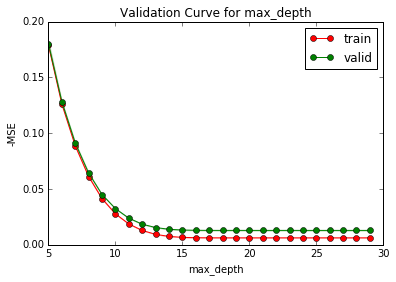

In [73]:
# Make a validation curve for the max depth parameter
train_size = int(0.5 * x_train.shape[0])
xt = x_train[:train_size, :]
yt = y_train[:train_size, :]

param_range = range(5, 30)
train_scores, valid_scores = validation_curve(tree.DecisionTreeRegressor(
        min_samples_leaf=5),
                                              xt, yt, 'max_depth', param_range,
                                              scoring='mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title('Validation Curve for max_depth')
plt.xlabel("max_depth")
plt.ylabel("-MSE")

plt.plot(param_range, -train_scores_mean, 'o-', label='train', color='r')
plt.fill_between(param_range, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(param_range, -valid_scores_mean, 'o-', label='valid', color='g')
plt.fill_between(param_range, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.2, color='g')
plt.legend(loc=0)

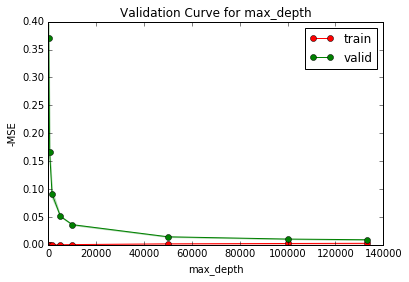

In [81]:
# Make a learning curve to find out how much training data to use
train_size = int(1 * x_train.shape[0])
xt = x_train[:train_size, :]
yt = y_train[:train_size, :]

train_sizes, train_scores, valid_scores = learning_curve(
    tree.DecisionTreeRegressor(max_depth=15), xt, yt,
    train_sizes=[100, 500, 1500, 5000, 10000, 50000, 100000, 133333],
    scoring='mean_squared_error')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure()
plt.title('Validation Curve for max_depth')
plt.xlabel("max_depth")
plt.ylabel("-MSE")

plt.plot(train_sizes, -train_scores_mean, 'o-', label='train', color='r')
plt.fill_between(train_sizes, -train_scores_mean - train_scores_std,
                -train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.plot(train_sizes, -valid_scores_mean, 'o-', label='valid', color='g')
plt.fill_between(train_sizes, -valid_scores_mean - valid_scores_std,
                -valid_scores_mean + valid_scores_std, alpha=0.2, color='g')
plt.legend(loc=0)

In [77]:
dtr_full = tree.DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
dtr_full = dtr_full.fit(xt, yt)

In [80]:
# get the scores for an output measure in the full tree
output_col = 2
print 'Scores for %s are:' % Y_COLUMNS[output_col]
print mean_squared_error(y_test[:, output_col],
                         dtr_full.predict(x_test)[:, output_col])
print r2_score(y_test[:, output_col],
               dtr_full.predict(x_test)[:, output_col])

print '\nScores for the overall fitted model are:'
print mean_squared_error(y_test.ravel(),
                         dtr_full.predict(x_test).ravel())
print r2_score(y_test.ravel(),
               dtr_full.predict(x_test).ravel())

Scores for heavytars are:
0.0139048314298
0.986068399346

Scores for the overall fitted model are:
0.0107107211493
0.989282361594


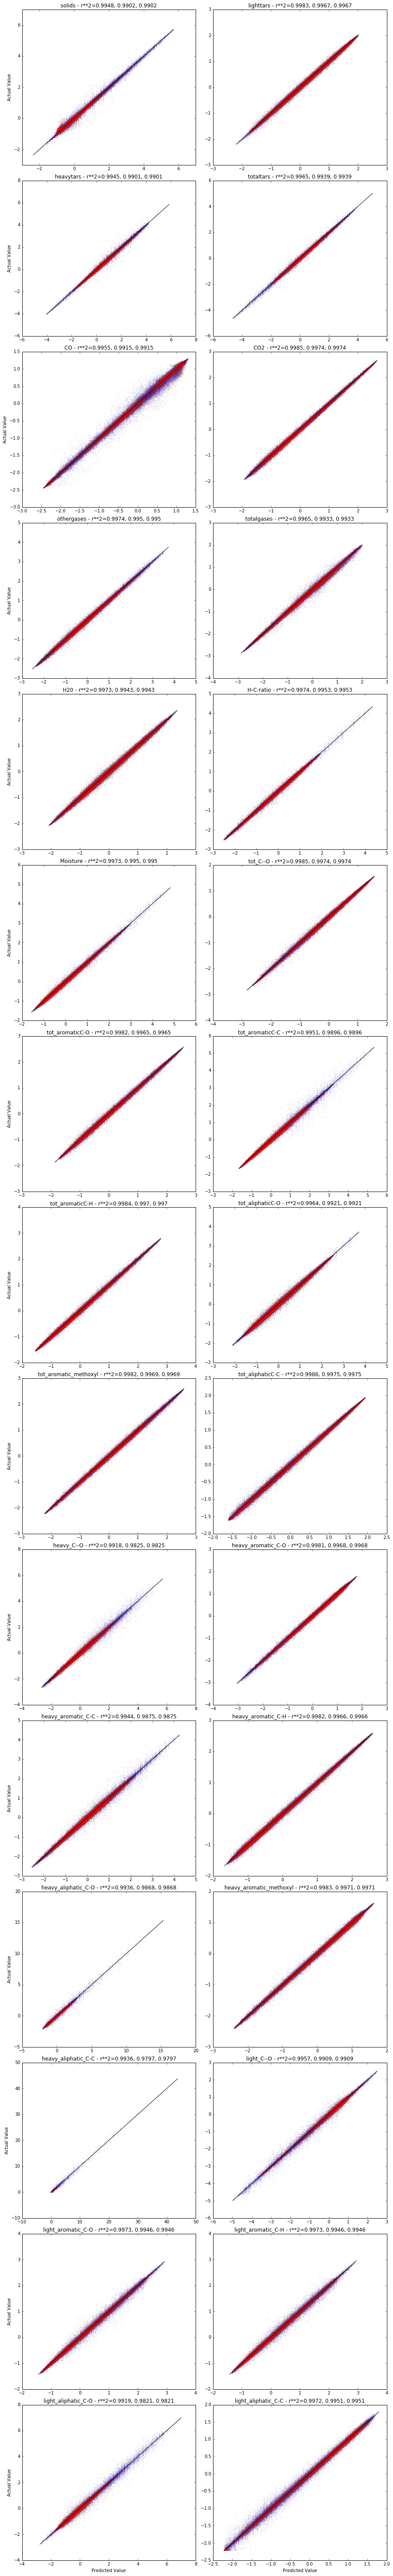

In [31]:
# Parity plots for the output measures in the full tree
# note there is no validation set so the test set is given twice
output_list = Y_COLUMNS
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

ytpred = dtr_full.predict(X)
ytestpred = dtr_full.predict(x_test)
yvpred = ytestpred

for key, name in enumerate(output_list):
    pplot_one_output_full(ax, y, y_test, y_test, ytpred, yvpred, ytestpred, key)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.1)